### Load required modules 

In [1]:
import torch
import warnings
import numpy as np
import scanpy as sc
import scarches as sca
import matplotlib.pyplot as plt

### Set up working environment

In [2]:
warnings.simplefilter(action = 'ignore')
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')
torch.set_printoptions(precision = 3, sci_mode = False, edgeitems = 7)

-----
anndata     0.7.5.dev71+g2723c9c
scanpy      1.8.0.dev65+g0712d9ab
sinfo       0.3.1
-----
PIL                 8.1.2
absl                NA
anndata             0.7.5.dev71+g2723c9c
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2021.05.30
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.3
google              NA
h5py                2.10.0
idna                2.10
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.17.0
joblib              1.0.1
kiwisolver          1.3.1
leidenalg           0.8.3
llvmlite            0.35.0
louvain             0.7.0
matplotlib          3.3.4
mkl                 2.3.0
mpl_toolkits        NA
nats

- Check GPU type assigned by `colab`

In [3]:
PT141_training = sc.read_h5ad('PT141_training.ctl210914.h5ad')
PT141_training

AnnData object with n_obs × n_vars = 12862 × 31135
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'

In [4]:
PT141_training.layers['counts'] = PT141_training.X.copy()

### Add module genes

- Here I have selected the C2 modules from the repo, and I have added the C3 Immune-related modules from GSEA. 

In [5]:
path_gmt = ''

sca.add_annotations(PT141_training, 
                    [path_gmt + 'c2.cp.reactome.v4.0.symbols.gmt', path_gmt + 'c3.all.v7.4.symbols.gmt', path_gmt + 'targets.csv'], 
                    min_genes = 10, clean = False)

PT141_training._inplace_subset_var(PT141_training.varm['I'].sum(1) > 0)

### Process module genes that match input
- Although the processed data comes with 7K HVGs already labelled in the `adata` object, I selected 2K HVGs to make things faster. 

In [6]:
sc.pp.highly_variable_genes(
    PT141_training,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True,
    span = 1
)
PT141_training

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 12862 × 7000
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'terms', 'hvg'
    varm: 'I'
    layers: 'counts'

In [7]:
select_terms = PT141_training.varm['I'].sum(0) > 20
PT141_training.uns['terms'] = np.array(PT141_training.uns['terms'])[select_terms].tolist()
PT141_training.varm['I'] = PT141_training.varm['I'][:, select_terms]
PT141_training._inplace_subset_var(PT141_training.varm['I'].sum(1) > 0)
PT141_training.X = PT141_training.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [8]:
PT141_training.X = PT141_training.X.toarray()

In [9]:
intr_cvae = sca.models.TRVAE(
    adata = PT141_training,
    condition_key = 'sample',
    hidden_layer_sizes = [1000, 600, 600],
    use_mmd = False,
    recon_loss = 'nb',
    mask = PT141_training.varm['I'].T,
    use_decoder_relu = False,
    mmd_instead_kl = False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 7000 1000 8
	Hidden Layer 1 in/out: 1000 600
	Hidden Layer 2 in/out: 600 600
	Mean/Var Layer in/out: 600 3127
Decoder Architecture:
	Masked linear layer in, out and cond:  3127 7000 8


- Set up training parameters 

In [10]:
ALPHA = 0.7

In [11]:
OMEGA = None

In [12]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [13]:
intr_cvae.train(
    n_epochs = 500, 
    alpha_epoch_anneal = 200, 
    alpha = ALPHA, 
    omega = OMEGA,
    alpha_kl = 0.1,
    weight_decay = 0., 
    early_stopping_kwargs = early_stopping_kwargs,
    use_early_stopping = True,
    seed = 1712,
    print_n_deactive = False)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |███-----------------| 17.2%  - epoch_loss: 2729.53 - epoch_recon_loss: 2710.64 - epoch_kl_loss:  444.38 - val_loss: 2888.93 - val_recon_loss: 2873.86 - val_kl_loss:  354.63
ADJUSTED LR
 |████----------------| 21.8%  - epoch_loss: 2735.58 - epoch_recon_loss: 2712.89 - epoch_kl_loss:  420.23 - val_loss: 2862.30 - val_recon_loss: 2843.32 - val_kl_loss:  351.44
ADJUSTED LR
 |█████---------------| 26.0%  - epoch_loss: 2746.61 - epoch_recon_loss: 2720.21 - epoch_kl_loss:  409.29 - val_loss: 2914.90 - val_recon_loss: 2893.20 - val_kl_loss:  336.44
ADJUSTED LR
 |█████---------------| 28.6%  - epoch_loss: 2738.34 - epoch_recon_loss: 2709.49 - epoch_kl_loss:  406.35 - val_loss: 2903.95 - val_recon_loss: 2880.26 - val_kl_loss:  333.75
ADJUSTED LR
 |██████--------------| 33.8%  - epoch_loss: 2750.49 - epoch_recon_loss: 2716.34 - epoch_kl_loss:  406.61 - val_loss: 2854.49 - val_recon_loss: 2826.94 - val_kl_loss:  327.94
ADJUSTED LR
 |███████-------------| 36.4%  - epoch_loss: 2745.73 - epoch_reco

### Checl terms in results

In [35]:
#intr_cvae.save('ko_model')

In [14]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p = 2, dim = 0) > 0).cpu().numpy()

In [18]:
print('Inactive terms:')
[term for i, term in enumerate(PT141_training.uns['terms']) if inactive_idx[i]]

Inactive terms:


['REACTOME_PI3K_AKT_ACTIVATION',
 'REACTOME_ACTIVATION_OF_CHAPERONE_GENES_BY_XBP1S',
 'REACTOME_CLASS_B_2_SECRETIN_FAMILY_RECEPTORS',
 'REACTOME_PLATELET_HOMEOSTASIS',
 'REACTOME_POTASSIUM_CHANNELS',
 'REACTOME_NUCLEOTIDE_BINDING_DOMAIN_LEUCINE_RICH_REPEAT_CONTAINING_RECEPTOR_NLR_SIGNALING_PATHWAYS',
 'MIR8075',
 'MIR4680_5P',
 'MIR4710',
 'MIR6794_3P',
 'MIR3156_3P',
 'MIR5589_5P',
 'MIR634',
 'MIR4296',
 'MIR4764_5P',
 'MIR331_5P',
 'MIR6734_5P',
 'MIR6072',
 'MIR2116_3P',
 'MIR574_5P',
 'MIR3661',
 'MIR3183',
 'MIR339_5P',
 'MIR550A_3_5P_MIR550A_5P',
 'MIR219B_3P',
 'MIR632',
 'MIR6762_5P',
 'MIR345_5P',
 'MIR6845_5P',
 'MIR4433B_5P',
 'MIR3130_3P',
 'MIR4757_5P',
 'MIR4438',
 'MIR4714_3P',
 'MIR519E_3P',
 'MIR515_3P',
 'MIR6862_5P',
 'MIR5011_3P',
 'MIR6769A_5P',
 'MIR7153_3P',
 'GTGGTGA_MIR197',
 'AGGCACT_MIR5153P',
 'GACAGGG_MIR339',
 'MYOGNF1_01',
 'EVI1_03']

### Visualise manifold

In [19]:
MEAN = False
PT141_training.obsm['X_cvae'] = intr_cvae.get_latent(mean = MEAN)[:, ~inactive_idx]

In [21]:
sc.pp.neighbors(PT141_training, use_rep = "X_cvae")
sc.tl.umap(PT141_training)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


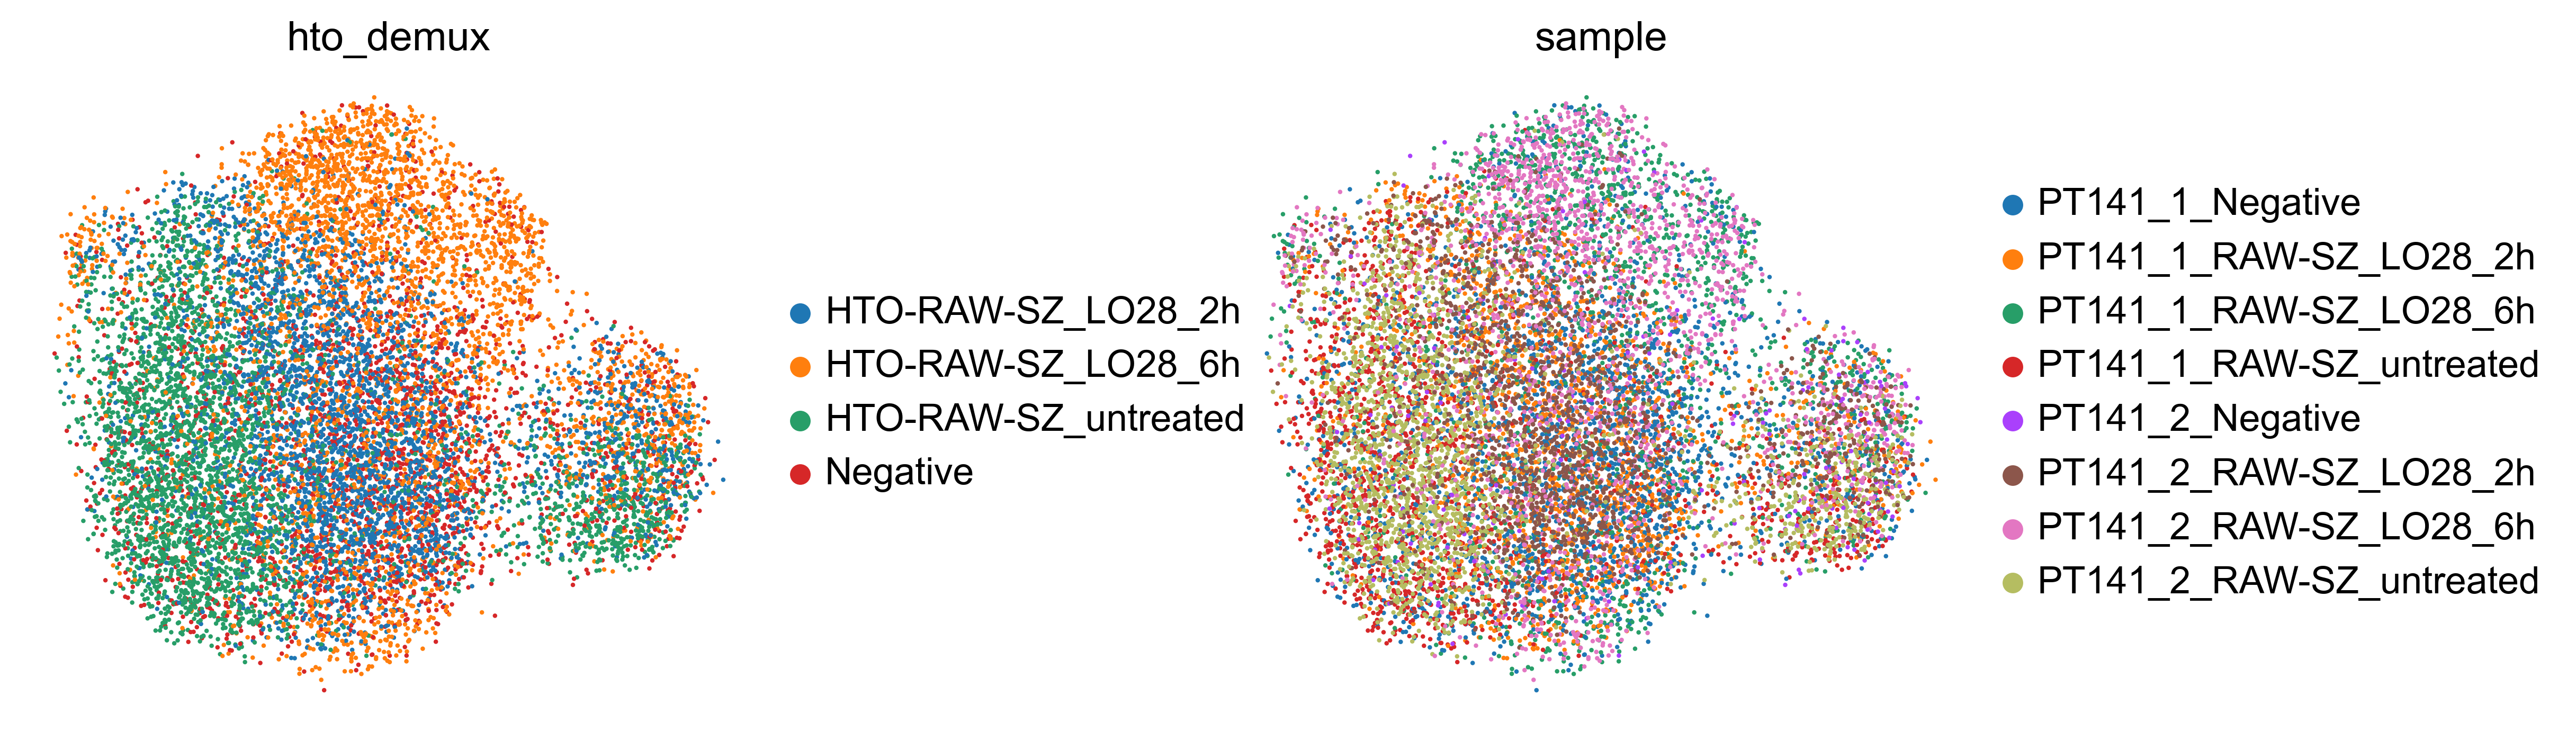

In [29]:
sc.pl.umap(PT141_training, frameon = False, color = ['hto_demux', 'sample'], wspace=0.5)

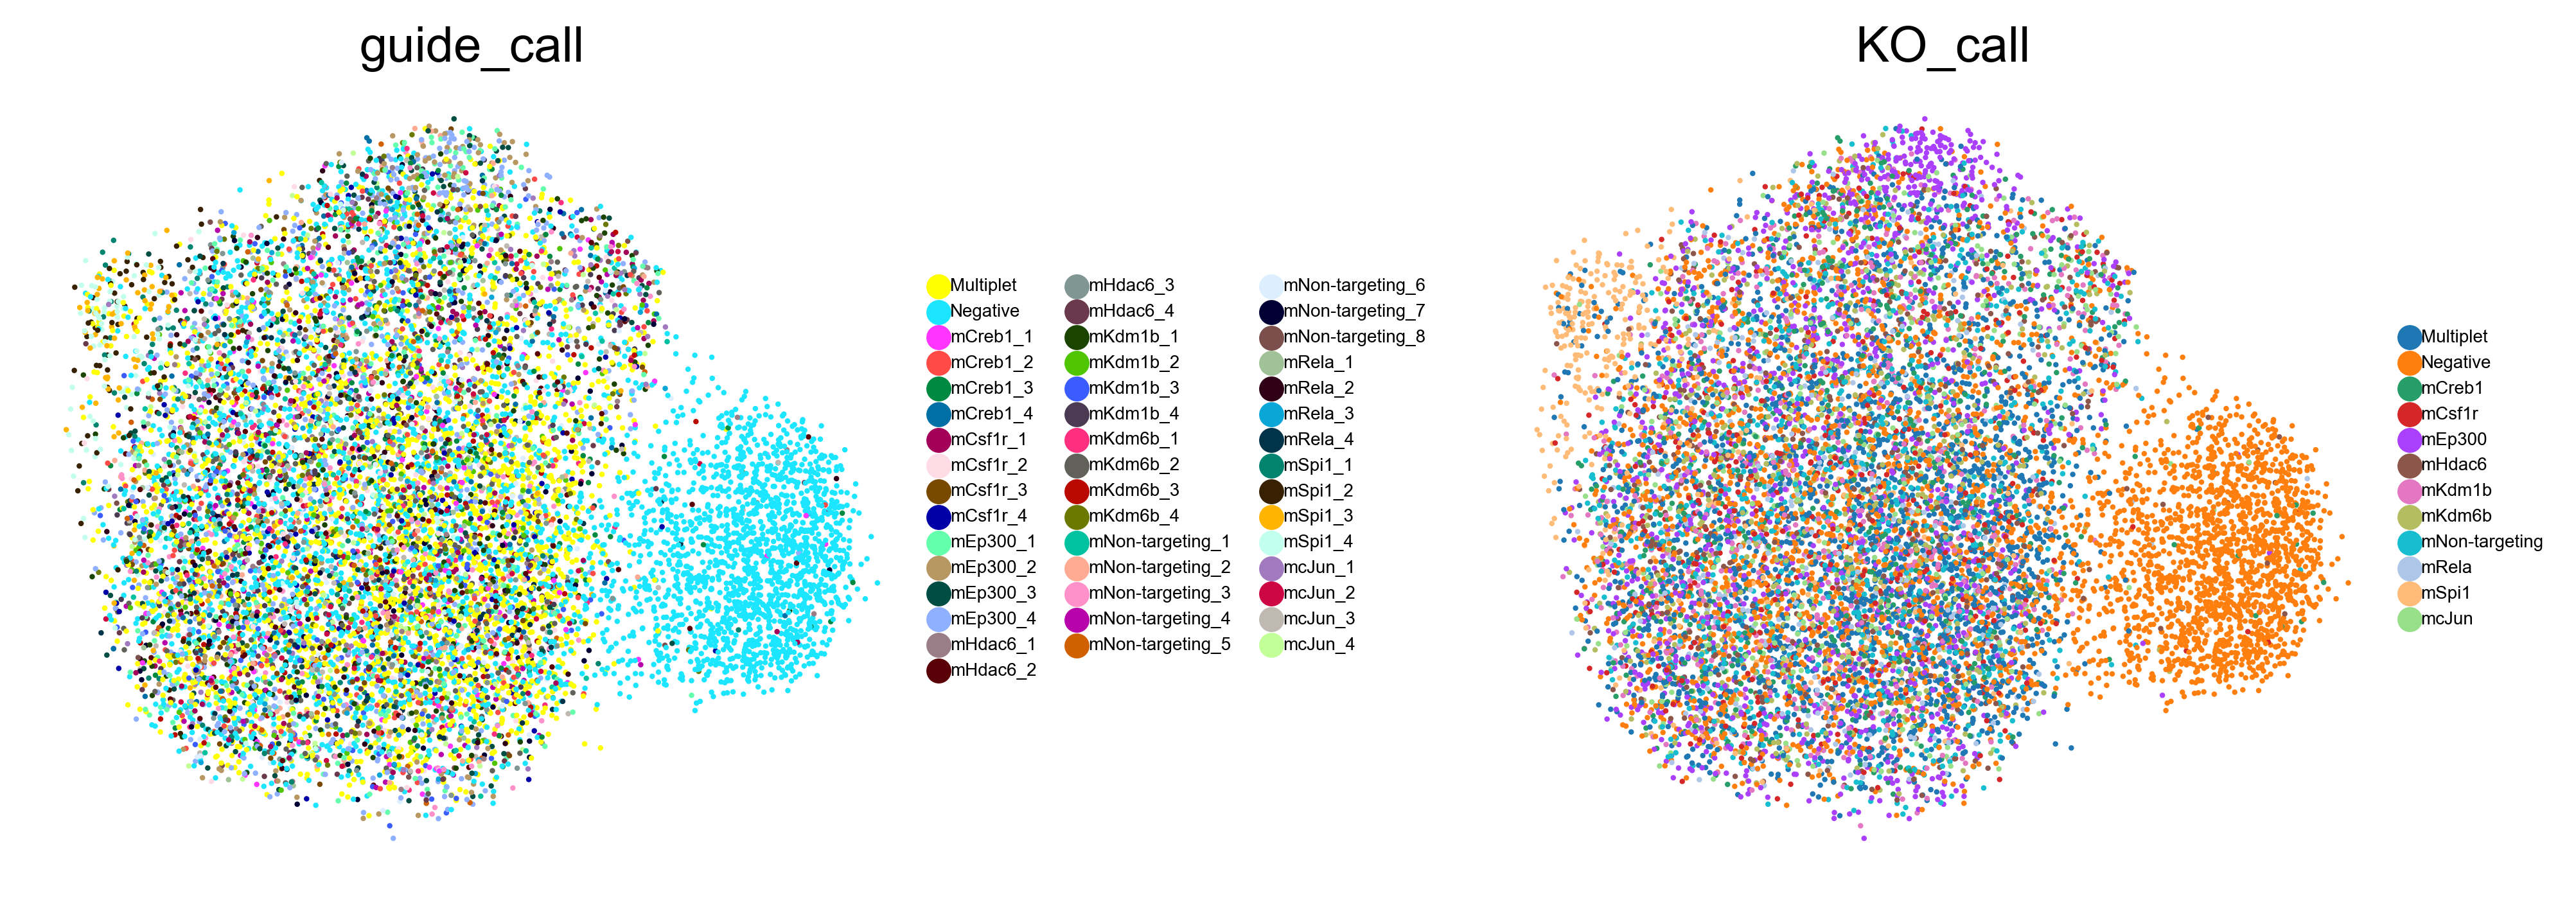

In [28]:
sc.pl.umap(PT141_training, frameon = False, color = ['guide_call', 'KO_call'], wspace=0.5, legend_fontsize = 5)

### Read in cells data

In [5]:
PT141_testing = sc.read_h5ad('PT141_testing.ctl210914.h5ad')[:, PT141_training.var_names].copy()
PT141_testing

AnnData object with n_obs × n_vars = 4283 × 31135
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'

### Format cells for analysis 

### Train on cells

In [31]:
PT141_testing.X = PT141_testing.X.toarray()

In [32]:
q_intr_cvae = sca.models.TRVAE.load_query_data(PT141_testing, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 7000 1000 8
	Hidden Layer 1 in/out: 1000 600
	Hidden Layer 2 in/out: 600 600
	Mean/Var Layer in/out: 600 3127
Decoder Architecture:
	Masked linear layer in, out and cond:  3127 7000 8


In [ ]:
q_intr_cvae.train(n_epochs = 500, alpha_epoch_anneal = 200, weight_decay = 0., alpha_kl = 0.1, seed = 1786)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |█-------------------| 8.4%  - epoch_loss: 3072.28 - epoch_recon_loss: 3064.58 - epoch_kl_loss:  375.86 - val_loss: 3322.26 - val_recon_loss: 3314.52 - val_kl_loss:  377.27
ADJUSTED LR
 |█-------------------| 9.8%  - epoch_loss: 3074.51 - epoch_recon_loss: 3065.50 - epoch_kl_loss:  375.57 - val_loss: 3301.35 - val_recon_loss: 3292.33 - val_kl_loss:  375.79
ADJUSTED LR
 |██------------------| 11.0%  - epoch_loss: 3090.36 - epoch_recon_loss: 3080.20 - epoch_kl_loss:  376.07 - val_loss: 3255.83 - val_recon_loss: 3245.69 - val_kl_loss:  375.42
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 54


### Visualise joint manifold

In [ ]:
PT141_testing.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [ ]:
sc.pp.neighbors(PT141_testing)
sc.tl.umap(PT141_testing)
sc.pl.umap(PT141_testing, frameon = False, color = ['hto_demux', 'sample', 'guide_call', 'KO_call'], legend_fontsize = 5)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


### Subset terms of interest

In [ ]:
terms = PT141_training.uns['terms']

In [ ]:
idx = [terms.index(term) for term in ['REACTOME_CELL_CELL_COMMUNICATION', 'REACTOME_INTERFERON_SIGNALING', 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING', 'REACTOME_INTERFERON_GAMMA_SIGNALING']]
latents = q_intr_cvae.get_latent(mean = MEAN)[:, idx]

- Explore terms in cell data

In [ ]:
PT141_testing.obs['REACTOME_CELL_CELL_COMMUNICATION'] = latents[:, 0]
PT141_testing.obs['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'] = latents[:, 1]
PT141_testing.obs['REACTOME_INTERFERON_GAMMA_SIGNALING'] = latents[:, 2]

In [ ]:
sc.pl.scatter(PT141_testing, x = 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING', y = 'REACTOME_INTERFERON_GAMMA_SIGNALING', color = 'KO_call', size = 22)

### Get joint representation

In [ ]:
ko_macro = sc.AnnData.concatenate(PT141_training, PT141_testing, batch_key = 'batch_join')
ko_macro

In [ ]:
ko_macro.obsm['X_cvae'] = q_intr_cvae.get_latent(ko_macro.X, ko_macro.obs['sample'].tolist(), mean = MEAN)[:, ~inactive_idx]

In [ ]:
sc.pp.neighbors(ko_macro, use_rep = "X_cvae")
sc.tl.umap(ko_macro)

In [ ]:
sc.pl.umap(ko_macro, frameon = False, color = ['hto_demux', 'sample'], wspace=0.5)

In [ ]:
sc.pl.umap(ko_macro, frameon = False, color = ['guide_call', 'KO_call'], wspace=0.5, legend_fontsize = 5)